In [23]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pickle
import numpy as np
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

# GLOVE Vectors
import torchtext.vocab as vocab

use_cuda = torch.cuda.is_available()
print(" I have a GPU? ", use_cuda)

 I have a GPU?  True


## Installing torchtext

The torchtext package is not currently on the PIP or Conda package managers, but it's easy to install manually:
may require sudo. 

```
git clone https://github.com/pytorch/text pytorch-text
cd pytorch-text
python setup.py install
```

In [24]:
glove = vocab.GloVe(name='6B', dim=50)

print('Loaded {} words'.format(len(glove.itos)))

Loaded 400000 words


The returned `GloVe` object includes attributes:
- `stoi` _string-to-index_ returns a dictionary of words to indexes
- `itos` _index-to-string_ returns an array of words by index
- `vectors` returns the actual vectors. To get a word vector get the index to get the vector:

In [25]:
glove.vectors[0][:5]


 0.4180
 0.2497
-0.4124
 0.1217
 0.3453
[torch.FloatTensor of size 5]

## Can skip the preprocessign step and just load the pickle file

In [154]:
class Lang:
    
    def __init__(self, name):
        
        '''
        Store the string token to index token
        mapping in the word2index and index2word
        dictionaries. 
        '''
        
        self.name = name
        self.trimmed = False # gets changed to True first time Lang.trim(min_count) is called
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.n_words = len(self.index2word) # Count default tokens
        self.num_nonwordtokens = len(self.index2word)
        self.PAD_token = 0
        self.SOS_token = 1
        self.EOS_token = 2
        self.UNK_token = 3

    def index_sentence(self, sentence):
        '''
        Absorbs a sentence string into the token dictionary
        one word at a time using the index_word function
        increments the word count dictionary as well
        '''
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    
    def trim(self, min_count):
        '''
        Removes words from our 3 dictionaries that
        are below a certain count threshold (min_count)
        '''
        if self.trimmed: return
        self.trimmed = True
        
        keep_words = []
        
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words %s / %s = %.4f' % (
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.n_words = len(self.index2word) # Count default tokens
        self.num_nonwordtokens = len(self.index2word)
        self.PAD_token = 0
        self.SOS_token = 1
        self.EOS_token = 2
        self.UNK_token = 3

        for word in keep_words:
            self.index_word(word)
            
    def unicode_to_ascii(self, s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn')
            
    def normalize_string(self, s):
        s = self.unicode_to_ascii(s.lower().strip())
        s = re.sub(r"([.!?])", r" \1", s)
        s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
        s = re.sub("newlinechar", "", s)
        s = s.replace("'","")
        s = s.replace(".","")
        s = s.replace("n t ","nt ")
        s = s.replace("i m ","im ")
        s = s.replace("t s ","ts ")
        s = s.replace(" s ","s ")
        s = s.replace(" re "," are ")
        s = s.replace("i ve ","ive ")
        s = s.replace(" d ","d ")
        s = ' '.join(s.split())
        return s

    def filterPair(self, p, max_sent_len, min_sent_len):
        
        '''
        Your Preferences here
        '''

        return len(p[0].split(' ')) < max_sent_len and \
               len(p[1].split(' ')) < max_sent_len and \
               len(p[1].split(' ')) > min_sent_len and \
               "https://" not in p[1] 

    
    def make_pairs(self, path_to_tab_sep_dialogue, 
                   max_sent_len = 20, min_sent_len = 4):

        print("making final_pairs list ...")
        lines = open(path_to_tab_sep_dialogue).read().strip().split('\n')
        
        final_pairs = []
        i = 0
        for l in lines:
            
            pair = [self.normalize_string(sentence) for sentence in l.split('\t')]
            
            if self.filterPair(pair,max_sent_len, min_sent_len):
                
                filtered_pair = []
                
                for sentence in pair:

                    self.index_sentence(sentence)
                    filtered_pair.append(sentence)
                  
                final_pairs.append(filtered_pair)
        print("number of pairs", len(final_pairs))
        return final_pairs
    
    def tokens2glove(self, min_word_count,glove, mbed_dim = 50):
    
        print("trimming...")    
        self.trim(min_word_count)
        
        if glove is None:
            glove = vocab.GloVe(name='6B', dim=embed_dim)
            print('Loaded {} words'.format(len(glove.itos)))
        else:
            embed_dim = glove.vectors.size(1)
                    
        print("building embedding from glove...")
        embedding = np.zeros((len(self.index2word), embed_dim)).astype(np.float32)
        for i in range(self.num_nonwordtokens):
            embedding[i,:] = np.random.uniform(-1,1,embed_dim).astype(np.float32)
        for i in range(self.num_nonwordtokens,len(self.index2word)):
            if self.index2word[i] in glove.stoi:
                embedding[i,:] = glove.vectors[glove.stoi[self.index2word[i]]]
            else:
                embedding[i,:] = np.random.uniform(-1,1,embed_dim).astype(np.float32)
        
        return self.index2word, self.word2index, embedding, self.n_words #torch.from_numpy(embeddings).float() 
    

In [207]:
MAX_SENT_LENGTH = 20
lang = Lang("chat")
final_pairs = lang.make_pairs("../data/input-output.txt", max_sent_len = MAX_SENT_LENGTH, 
                              min_sent_len = 3)
index2word, word2index, embedding, vocab_size = lang.tokens2glove(5,glove)

making final_pairs list ...
number of pairs 317106
trimming...
keep_words 22348 / 52457 = 0.4260
building embedding from glove...


In [156]:
final_pairs

[['what ?', 'you just burned the desk'],
 ['a married lady', 'with the paper to prove it'],
 ['cant we get a couple whores over ?', 'you aint even a man yet'],
 ['at first', 'you got anybody wick ?'],
 ['that looks like fifty thousand dollars from here', 'this is your money ?'],
 ['this is your money ?', 'if i were to tell you no it isnt'],
 ['of course', 'it was not inspired by circumstance'],
 ['it was not inspired by circumstance', 'no it most certainly was not'],
 ['jack you are wrong', 'good afternoon mr brumby carter exits'],
 ['next stop', 'pizza planet ! yeah ! ! !'],
 ['hi daddy', 'well what happened to you ?'],
 ['no why ?', 'you sure hes not italian ?'],
 ['do i ?', 'it happens take it easy'],
 ['whats up with you ?', 'me ? nothing tell me more about the job'],
 ['do you like this hotel ?', 'yes i do i love it dont you ?'],
 ['well i think its getting late good night ninotchka',
  'thank you for a wonderful dinner'],
 ['the goddamn smell is always the same',
  'are you going

In [ ]:
new_pairs = []
for pair in final_pairs:
    if len(pair[1].split(" ")) > 3:
        pair[1] = pair[1].replace(".","")
        new_pairs.append([pair[0],pair[1]])
        
new_pairs

In [43]:
mx_sent_30_min_sent_1_min_wrd_10_dim50 = (index2word, word2index, embedding, final_pairs, vocab_size)

In [44]:
pickle.dump(mx_sent_30_min_sent_1_min_wrd_10_dim50, open( "saved_pickle/mx_sent_30_min_sent_1_min_wrd_10_dim50.p", "wb" ) )

In [30]:
index2word, word2index, embedding, final_pairs, vocab_size  = \
pickle.load( open( "saved_pickle/mx_sent_30_min_sent_1_min_wrd_10_dim50.p", "rb" ) )

## Makesure the GloVe vectors work the way they are supposed to

In [157]:
np.dot(embedding[word2index["admire"]],embedding[word2index["respect"]])

12.615148

In [158]:
np.dot(embedding[word2index["admire"]],embedding[word2index["sad"]])

8.4504595

In [159]:
np.dot(embedding[word2index["sad"]],embedding[word2index["depressed"]])

12.561041

In [130]:
##########  Converts [" input string ", " output string "] (pair) , appends <EOS> index and returns indices ######

def indexesFromSentence(lang, sentence):
    '''
    account for strings not in the vocabulary by using the unknown token
    '''
    sentence_as_indices = []
    for word in sentence.split(' '):
        if word in lang.word2index:
            sentence_as_indices.append(lang.word2index[word])
        else:
            sentence_as_indices.append(lang.UNK_token)
    
    return sentence_as_indices


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(lang.EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair,lang):
    input_variable = variableFromSentence(lang, pair[0])
    target_variable = variableFromSentence(lang, pair[1])
    return (input_variable, target_variable)

######## the pair indices are returned as 2 LongTensor Variables in torch #############


######## Tells you how long youve been training and how much longer you have left ####

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

######################################################################3

############### plot_losses #######################################

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
####################################################################

In [163]:
class EncoderRNN(nn.Module):
    
    def __init__(self, hidden_size, embedding,
                 num_layers = 3, bidirectional = False, train_embedding = True):
        
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        embedding = torch.from_numpy(embedding).float()
        self.embedding = nn.Embedding(embedding.shape[0], embedding.shape[1])
        self.embedding.weight = nn.Parameter(embedding, requires_grad=train_embedding)
        self.gru = nn.GRU(embedding.shape[1], hidden_size, num_layers, bidirectional=bidirectional)
        
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1
        
        # make the initial hidden state learnable as well 
        hidden0 = torch.zeros(self.num_layers*num_directions, 1, self.hidden_size)
        
        if use_cuda:
            hidden0 = hidden0.cuda()
        else:
            hidden0 = hidden0

        self.hidden0 = nn.Parameter(hidden0, requires_grad=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        
        if self.bidirectional:
            output = output[:, :, :self.hidden_size] + output[:, : ,self.hidden_size:] # Sum bidirectional outputs
            
        return output, hidden

    def initHidden(self):
        
        if use_cuda:
            return self.hidden0.cuda()
        else:
            return self.hidden0

In [174]:
class AttnDecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, embedding, dropout_p=0.1,  
                 num_layers = 3, train_embedding = True, max_length=30):
        
        super(AttnDecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.num_layers = num_layers
        embedding = torch.from_numpy(embedding).float()
        self.embedding = nn.Embedding(embedding.shape[0], embedding.shape[1])
        self.embedding.weight = nn.Parameter(embedding, requires_grad=train_embedding)
        
        self.attn = nn.Linear(self.hidden_size + embedding.shape[1], self.max_length)
        
        self.attn_combine = nn.Linear(self.hidden_size + embedding.shape[1], self.hidden_size)
        
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, num_layers = num_layers)
        self.out = nn.Linear(self.hidden_size, embedding.shape[0])
        
        hidden0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        
        if use_cuda:
            hidden0 = hidden0.cuda()
        else:
            hidden0 = hidden0

        self.hidden0 = nn.Parameter(hidden0, requires_grad=True)

    def forward(self, input, hidden, encoder_outputs):
        
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        cat = torch.cat((embedded[0], hidden[0]), 1)
        attn = self.attn(cat)
        
        attn_weights = F.softmax(attn, dim=1)
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        
        if use_cuda:
            return self.hidden0.cuda()
        else:
            return self.hidden0

In [179]:

def train(lang, input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, max_length=30, teacher_forcing_ratio = 0.5, bidirectional = False):
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]

    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[lang.SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    if bidirectional:
        # sum the bidirectional hidden states into num_layers long cause the decoder is not bidirectional
        encoder_hidden = encoder_hidden[:encoder.num_layers, :, :] + encoder_hidden[encoder.num_layers:, : ,:] 
        
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):

            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == lang.EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [211]:
def trainIters(encoder, decoder, pairs, lang, n_iters =1000, print_every=100, plot_every=100,
               learning_rate=0.01, teacher_forcing_ratio = 0.5, bidirectional = False,
               name = "noname", lowest_loss =100, max_length = 30, gamma = 0.95):
    
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    #encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    #decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    escheduler = optim.lr_scheduler.StepLR(encoder_optimizer, step_size=print_every, gamma=gamma) 
    dscheduler = optim.lr_scheduler.StepLR(decoder_optimizer, step_size=print_every, gamma=gamma) 
    
    training_pairs = [variablesFromPair(random.choice(pairs),lang)
                      for i in range(n_iters)]
    
    criterion = nn.NLLLoss()

    lowest_loss = lowest_loss
    
    for iter in range(1, n_iters + 1):
        
        escheduler.step()
        dscheduler.step()
        
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(lang, input_variable, target_variable, encoder, decoder, 
                     encoder_optimizer, decoder_optimizer, criterion, 
                     teacher_forcing_ratio = teacher_forcing_ratio,
                     max_length = max_length, bidirectional =  bidirectional)
        
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            
            if lowest_loss > print_loss_avg:
                lowest_loss = print_loss_avg
                print("new lowest loss, saving...")
                torch.save(encoder.state_dict(), "saved_params/encoder"+name+".pth")
                torch.save(attn_decoder.state_dict(), "saved_params/attn_decoder"+name+".pth")

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0


    showPlot(plot_losses)

In [212]:
hidden_size = 1024
num_layers = 2
bidirectional = True 

encoder = EncoderRNN(hidden_size, embedding, num_layers = num_layers, bidirectional = bidirectional,
                     train_embedding = True)


attn_decoder = AttnDecoderRNN(hidden_size,  embedding, dropout_p=0.1, num_layers = num_layers,
                               train_embedding = True, max_length = MAX_SENT_LENGTH)

if use_cuda:
    encoder = encoder.cuda()
    attn_decoder = attn_decoder.cuda()
    

version = 0
name = "hidden" + str(hidden_size) + "L" + str(num_layers) + "bidir"+str(bidirectional) + "v"+ str(version)

In [195]:
#encoder.load_state_dict(torch.load("saved_params/encoder"+name+".pth"))
#attn_decoder.load_state_dict(torch.load("saved_params/attn_decoder"+name+".pth"))
#name = "_256h_4L_bi_glove"
encoder.load_state_dict(torch.load("saved_params/encoder"+name+".pth"))
attn_decoder.load_state_dict(torch.load("saved_params/attn_decoder"+name+".pth"))

version = 3
name = "hidden" + str(hidden_size) + "L" + str(num_layers) + "bidir"+str(bidirectional) + "v"+ str(version)

In [ ]:
trainIters(encoder, attn_decoder, final_pairs, lang, n_iters = 100000, print_every=10000, 
           learning_rate=0.01, teacher_forcing_ratio = 0.99,
           bidirectional = bidirectional, name = name,
           max_length = MAX_SENT_LENGTH, lowest_loss = 4.0, gamma = 0.5)

In [76]:
#name = "_256h_4L_bi_glove"
torch.save(encoder.state_dict(), "saved_params/encoder"+name+".pth")
torch.save(attn_decoder.state_dict(), "saved_params/attn_decoder"+name+".pth")

In [77]:
# save cpu version

encoder.cpu()
attn_decoder.cpu()

torch.save(encoder.state_dict(), "saved_params/encoder"+name+"cpu.pth")
torch.save(attn_decoder.state_dict(), "saved_params/attn_decoder"+name+"cpu.pth")

input from data > there is pastel bloc but it didnt catch on
output from data= beige bloc could be a good look
bot response < you are in the <UNK> <EOS>

input from data > what the fuck are you doing here ?
output from data= do you remember me ?
bot response < you are <UNK> me <EOS>

input from data > what specifically
output from data= grunge classic rock hard rock alternative rock
bot response < you are <UNK> me <EOS>

input from data > gatorade
output from data= what happened to all the gatorade ?
bot response < you are <UNK> me <EOS>

input from data > thanks autocorrect
output from data= no i did it on purpose lol
bot response < you are a <UNK> <UNK> <EOS>

input from data > a most courteous exposition
output from data= nay i am the very pink of courtesy
bot response < you are a <UNK> <UNK> <EOS>

input from data > huh ?
output from data= so yvonnes gone over to the enemy
bot response < you know what you said <EOS>

input from data > thats right
output from data= complicated or no

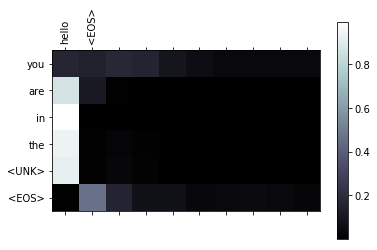

input = what link ?
output = you are <UNK> me <EOS>


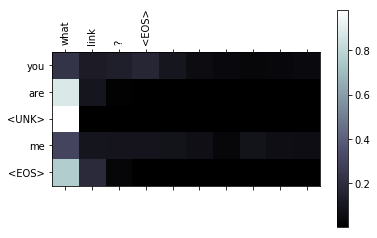

input = why is this happening ?
output = you know i was a <UNK> <EOS>


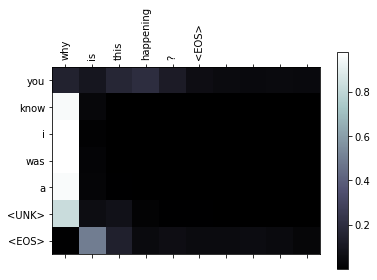

input = tell me something stupid
output = you are a <UNK> <EOS>


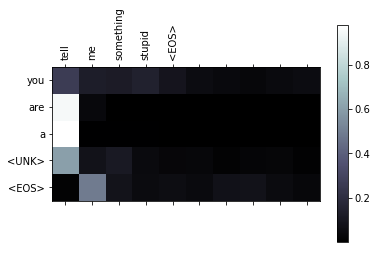

input = you can make it if you try
output = i dont think i should get a <UNK> <EOS>


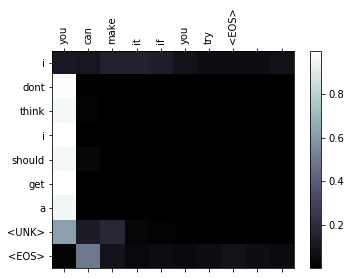

input = where are we and where are we going ?
output = you are a <UNK> <EOS>


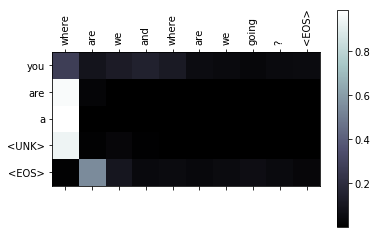

In [206]:
evaluateRandomly(final_pairs, encoder, attn_decoder,  n=10, bidirectional = bidirectional)

evaluateAndShowAttention("hello",encoder, attn_decoder, bidirectional = bidirectional)

evaluateAndShowAttention("what link ?",encoder, attn_decoder, bidirectional = bidirectional)

evaluateAndShowAttention("why is this happening ?",encoder, attn_decoder, bidirectional = bidirectional)

evaluateAndShowAttention("tell me something stupid",encoder, attn_decoder, bidirectional = bidirectional)

evaluateAndShowAttention("you can make it if you try",encoder, attn_decoder, bidirectional = bidirectional)

evaluateAndShowAttention("where are we and where are we going ?",
                         encoder, attn_decoder, bidirectional = bidirectional  )

In [186]:
def evaluate(encoder, decoder, sentence, max_length=MAX_SENT_LENGTH,
             bidirectional =bidirectional):
    
    
    input_variable = variableFromSentence(lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[lang.SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    if bidirectional:
        # sum the bidirectional hidden states into num_layers long cause the decoder is not bidirectional
        encoder_hidden = encoder_hidden[:encoder.num_layers, :, :] + encoder_hidden[encoder.num_layers:, : ,:]

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == lang.EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

def evaluateRandomly(pairs, encoder, decoder, n=10, bidirectional = False):
    for i in range(n):
        pair = random.choice(pairs)
        print('input from data >', pair[0])
        print('output from data=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0], bidirectional = bidirectional)
        output_sentence = ' '.join(output_words)
        print('bot response <', output_sentence)
        print('')
        
def showAttention(input_sentence, output_words, attentions, bidirectional = False):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence,encoder, attn_decoder, bidirectional = False):
    
    output_words, attentions = evaluate(encoder, attn_decoder, input_sentence, bidirectional = bidirectional)
    
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

# Reinforcement Learning

In [97]:
backward_encoder = EncoderRNN(output_lang.n_words, hidden_size, num_layers = num_layers,
                              bidirectional = bidirectional)

backward_attn_decoder = AttnDecoderRNN(hidden_size, input_lang.n_words, dropout_p=0.1, 
                                       num_layers = num_layers)

In [ ]:
trainIters(backward_encoder, backward_attn_decoder, n_iters = 10000, print_every=1000, 
           learning_rate=0.0001, teacher_forcing_ratio = 0.75,
           bidirectional = bidirectional, reverse=True)

## The main training loops is trainRLIters(), it calls RLStep to get the forward loss, it calls calculate_rewards to get the rewards for each forward_loss element, the two are multiplied to ge the final loss as per REINFORCE. This final Loss is backpropagated 